# INFO 5613 – Class 01: Test Notebook

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT)

## Does this notebook work?

In [9]:
a_sum = 1+1
print(a_sum)

2


In [10]:
a_sum

2

In [7]:
print("{0} has the best haircut of any INFO faculty!".format('Brian Keegan'))

Brian Keegan has the best haircut of any INFO faculty!


In [11]:
a_sum + 1

3

## Can you load libraries?

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS

import numpy as np
import pandas as pd
import json, requests
import networkx as nx

from itertools import combinations

pd.options.display.max_columns = 50

## Can you load data?

We'll use the exquistely detailed data collected and shared by [Jeffrey Lancaster about *Game of Thrones*](https://github.com/jeffreylancaster/game-of-thrones). The "episodes" data contains information about the characters present in each scene of each episode.

In [12]:
# Get the data
got_episodes_json = requests.get('https://raw.githubusercontent.com/jeffreylancaster/game-of-thrones/master/data/episodes.json').json()

# Inspect the data
got_episodes_json['episodes'][0]['scenes'][0]

{'sceneStart': '0:00:40',
 'sceneEnd': '0:01:45',
 'location': 'The Wall',
 'subLocation': 'Castle Black',
 'characters': [{'name': 'Gared'}, {'name': 'Waymar Royce'}, {'name': 'Will'}]}

In [13]:
got_episodes_json['episodes'][0]['scenes'][-1]

{'sceneStart': '0:59:06',
 'sceneEnd': '1:00:57',
 'location': 'The North',
 'subLocation': 'Winterfell',
 'characters': [{'name': 'Bran Stark'},
  {'name': 'Summer'},
  {'name': 'Jaime Lannister',
   'sex': {'with': ['Cersei Lannister'], 'when': 'present', 'type': 'love'}},
  {'name': 'Cersei Lannister',
   'sex': {'with': ['Jaime Lannister'], 'when': 'present', 'type': 'love'}}]}

For the three `characters` in this scene, we'll connect them all together.

In [14]:
list(combinations([c['name'] for c in got_episodes_json['episodes'][0]['scenes'][0]['characters']],2))

[('Gared', 'Waymar Royce'), ('Gared', 'Will'), ('Waymar Royce', 'Will')]

## Data cleaning
Manipulate the data to make a simple edgelist of the characters present in each scene of S01E01.

In [15]:
scene_char_combos = {}

for i,scene in enumerate(got_episodes_json['episodes'][0]['scenes']):
    scene_char_combos[i] = list(combinations([c['name'] for c in scene['characters']],2))
    
list(scene_char_combos.items())[:10]

[(0, [('Gared', 'Waymar Royce'), ('Gared', 'Will'), ('Waymar Royce', 'Will')]),
 (1, [('Gared', 'Waymar Royce'), ('Gared', 'Will'), ('Waymar Royce', 'Will')]),
 (2, [('Will', 'Wight Wildling Girl')]),
 (3, []),
 (4, []),
 (5, [('Gared', 'Waymar Royce'), ('Gared', 'Will'), ('Waymar Royce', 'Will')]),
 (6, []),
 (7, [('Gared', 'Waymar Royce')]),
 (8, []),
 (9,
  [('Gared', 'Waymar Royce'),
   ('Gared', 'White Walker'),
   ('Waymar Royce', 'White Walker')])]

## Create network
Make our first network.

In [16]:
# Start with an empty undirected graph
g = nx.Graph()

# For each scene and its list of character combinations
for scene, combolist in scene_char_combos.items():
    
    # For each character combination
    for (char1,char2) in combolist:
        
        # Check if the character combination is already in the network
        if g.has_edge(char1,char2):
            
            # If it is, increment the edge weight by 1
            g[char1][char2]['weight'] += 1
            
        else:
            # If it is not, add the nodes and the edge with a weight of 1
            g.add_edge(char1,char2,weight=1)

Inspect network.

In [17]:
g.number_of_nodes()

45

In [18]:
g.number_of_edges()

350

In [19]:
list(g.edges(data=True))[:10]

[('Gared', 'Waymar Royce', {'weight': 5}),
 ('Gared', 'Will', {'weight': 4}),
 ('Gared', 'White Walker', {'weight': 2}),
 ('Waymar Royce', 'Will', {'weight': 3}),
 ('Waymar Royce', 'White Walker', {'weight': 1}),
 ('Will', 'Wight Wildling Girl', {'weight': 2}),
 ('Will', 'White Walker', {'weight': 1}),
 ('Will', 'Jon Snow', {'weight': 2}),
 ('Will', 'Bran Stark', {'weight': 2}),
 ('Will', 'Robb Stark', {'weight': 2})]

## Visualize the network

In [20]:
# Compute node positions
pos = nx.drawing.spring_layout(g,k=2,seed=42,iterations=100)

In [21]:
# Compute node degree centrality
centrality = nx.degree_centrality(g)

In [22]:
# Compute communities - this might take a few seconds
communities = nx.community.naive_greedy_modularity_communities(g)

In [23]:
# Assign colors to nodes based on their community membership
comm_color = {}

for n in g.nodes():    
    for i,comm in enumerate(communities):
        for char in list(comm):
            if n == char:
                comm_color[n] = list(TABLEAU_COLORS.values())[i]

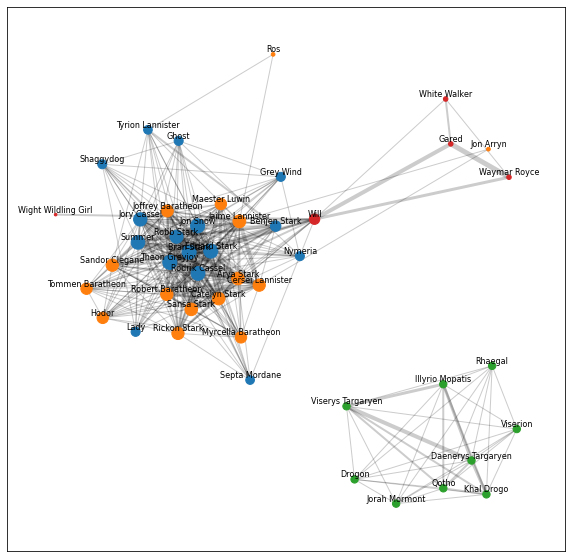

In [24]:
# Create an empty canvas
f,ax = plt.subplots(figsize=(10,10))

# Draw the nodes, sized by centrality
nx.draw_networkx_nodes(g,
                       pos=pos,
                       node_size=[v*300 for n,v in centrality.items()],
                       node_color=comm_color.values(),
                       ax=ax
                      )

# Draw the edges, sized by weight (number of scenes together)
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=.2,
                       width=[d['weight'] for i,j,d in g.edges(data=True)],
                       ax=ax
                      )

# Draw the node labels
nx.draw_networkx_labels(g,
                        pos=pos,
                        font_size=8,
                        verticalalignment='bottom',
                        ax=ax
                       );